In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import networkx as nx

# Load the data

In [3]:
# make a degree diction for the graph
# read these triples: ELs_for_Rotate/Monarch_KG/train.txt

# read the triples
# read the triples
file_path = '../ELs_for_Rotate/Monarch_KG/train.txt'
df = pd.read_csv(file_path, sep='\t', header=None)
df.columns = ['head', 'relation', 'tail']
df.head()
# make a graph
G = nx.from_pandas_edgelist(df, 'head', 'tail', create_using=nx.DiGraph())
# make a degree dictionary
degree_dict = dict(G.degree(G.nodes()))

In [4]:
# ,head_label,relation_label,tail_label,rank,head_degree,tail_degree,population
df_euro_afr = pd.read_csv('../GroupComparisonResults/ASVD/euro_afr_gene_causes_mondo_European_v_African_g2p_rankings_hist.csv')

sub = df_euro_afr[df_euro_afr['tail_label']=='MONDO:0054743']
print(sub.head())

df_asian = pd.read_csv('../GroupComparisonResults/ASVD/euro_eas_gene_causes_mondo_European_v_East_Asian_g2p_rankings_hist.csv')
df_latino = pd.read_csv('../GroupComparisonResults/ASVD/euro_latino_gene_causes_mondo_European_v_Latino_g2p_rankings_hist.csv')
# split euro and african from df_euro_afr into seporate dfs
df_euro = df_euro_afr[df_euro_afr['population']=='European']
df_afr = df_euro_afr[df_euro_afr['population']=='African']
# remove European from asian and latino dfs
df_eas = df_asian[df_asian['population']!='European']
df_lat = df_latino[df_latino['population']=='Latino']
# combine all dfs into one
df_asvd = pd.concat([df_euro,df_afr,df_eas,df_lat])
# add a column for the predicted entity type - the node I predicted with pykeen, the opposite is the piece of information specific to the group
df_asvd['predicted_entity'] = 'head'

cancer_df = pd.read_csv('../GroupComparisonResults/CancerVsRandom/monarch_transE_Cancer_v_Random_500_42_g2p_rankings_hist.csv')
cancer_df['predicted_entity'] = 'tail'
# replace Random_500_42 with Random in cancer
cancer_df['population'] = cancer_df['population'].replace('Random_500_42','Random')
sex_df = pd.read_csv('../GroupComparisonResults/SexDiffExp/sex_diff_genes_mondo_Female_v_Male_g2p_rankings_hist.csv')
sex_df['predicted_entity'] = 'tail'

# remove degree columns
df_asvd = df_asvd.drop(columns=['head_degree','tail_degree'])
cancer_df = cancer_df.drop(columns=['head_degree','tail_degree'])
sex_df = sex_df.drop(columns=['head_degree','tail_degree'])

# re add the degree columns using head and tail labels and the degree dictionary
df_asvd['head_degree'] = df_asvd['head_label'].map(degree_dict)
df_asvd['tail_degree'] = df_asvd['tail_label'].map(degree_dict)
cancer_df['head_degree'] = cancer_df['head_label'].map(degree_dict)
cancer_df['tail_degree'] = cancer_df['tail_label'].map(degree_dict)
sex_df['head_degree'] = sex_df['head_label'].map(degree_dict)
sex_df['tail_degree'] = sex_df['tail_label'].map(degree_dict)

# add a for the predicted entity degree and the given entity degree
df_asvd['predicted_entity_degree'] = df_asvd['head_degree']
df_asvd['given_entity_degree'] = df_asvd['tail_degree']
cancer_df['predicted_entity_degree'] = cancer_df['tail_degree']
cancer_df['given_entity_degree'] = cancer_df['head_degree']
sex_df['predicted_entity_degree'] = sex_df['tail_degree']
sex_df['given_entity_degree'] = sex_df['head_degree']

sub = df_asvd[df_asvd['tail_label']=='MONDO:0054743']

non_medianed_df = pd.concat([df_asvd,cancer_df,sex_df])

# unique number of head nodes in sex_df
print(len(sex_df['head_label'].unique()))
# for sex_df group by head_label and population and get the median rank
sex_df = sex_df[['population','head_label','rank','given_entity_degree']].groupby(['population','head_label']).median().reset_index().sort_values(by='rank',ascending=True)
# same thing for cancer_df
cancer_df = cancer_df[['population','head_label','rank','given_entity_degree','predicted_entity_degree']].groupby(['population','head_label']).median().reset_index().sort_values(by='rank',ascending=True)
# same thing for df_asvd but use tail_label instead of head_label
df_asvd = df_asvd[['population','tail_label','rank','given_entity_degree','predicted_entity_degree']].groupby(['population','tail_label']).median().reset_index().sort_values(by='rank',ascending=True)

# combine all dfs into one
df = pd.concat([df_asvd,cancer_df,sex_df])

# print the number of rows in each "Population category"
print('Number of rows in each population category:')
for pop in df['population'].unique():
    print(pop,':',len(df[df['population']==pop]))


Empty DataFrame
Columns: [Unnamed: 0, head_label, relation_label, tail_label, rank, head_degree, tail_degree, population]
Index: []
9509
Number of rows in each population category:
European : 92
Latino : 65
African : 44
East_Asian : 45
Random : 1239
Cancer : 342
Female : 6842
Male : 6533


In [5]:
# head of african pops
print('Head of African pops:')
print(df[df['population']=='African'].head())

Head of African pops:
   population     tail_label      rank  given_entity_degree  \
42    African  MONDO:0054801  0.127332                  4.0   
7     African  MONDO:0008185  0.137345                 26.0   
12    African  MONDO:0008673  0.200161                 27.0   
38    African  MONDO:0014508  0.222075                  8.0   
4     African  MONDO:0007390  0.243282                  5.0   

    predicted_entity_degree head_label  
42                    373.0        NaN  
7                     133.0        NaN  
12                    100.0        NaN  
38                     55.0        NaN  
4                     215.0        NaN  


# Degree vs rank

['Female', 'Male', 'European', 'African', 'East_Asian', 'Latino', 'Cancer', 'Random']
[6842, 6533, 92, 44, 45, 65, 342, 1239]
['Female', 'Male', 'European', 'African', 'East_Asian', 'Latino', 'Cancer', 'Random']


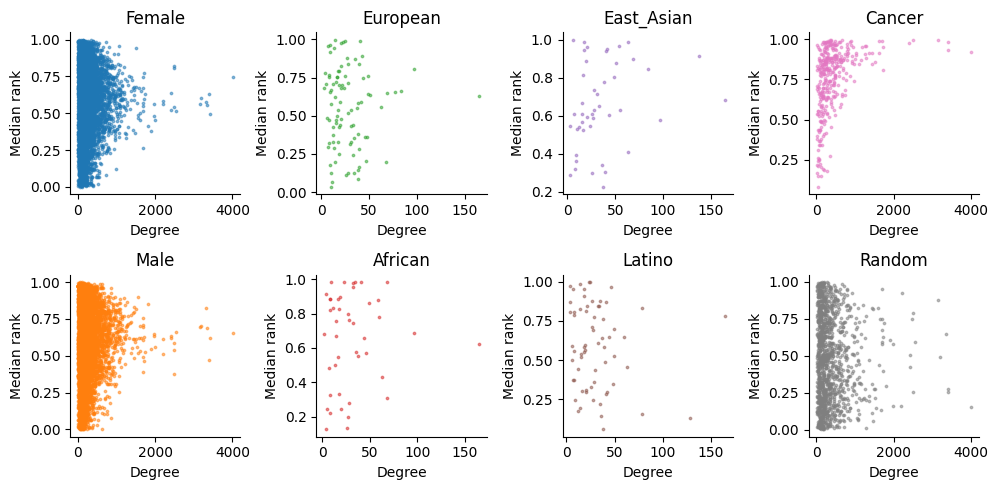

In [11]:
# for each population, plot the rank vs degree

# list populations in order of the number of rows in the df
# sort populations by number of rows
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
populations = ['Female','Male','European','African','East_Asian','Latino','Cancer','Random']

pop_counts = [df[df['population']==p].shape[0] for p in populations]

# sort population based on pop_counts
print(populations)
print(pop_counts)
# populations = [x for _,x in sorted(zip(pop_counts,populations),reverse=True)]
print(populations)

fig, axes = plt.subplots(2,4,figsize=(10,5))

for i,pop in enumerate(populations):
    x = i%2
    y = i//2
    df_pop = df[df['population']==pop]
    axes[x,y].scatter(df_pop['given_entity_degree'],df_pop['rank'],label=pop,s=3,alpha=0.5,color=colors[i])
    # log x
    # if pop not in ['European','African','East_Asian','Latino']:
    #     axes[x,y].set_xscale('log')

    # remove top and right border
    axes[x,y].spines['top'].set_visible(False)
    axes[x,y].spines['right'].set_visible(False)
    # set x and y labels
    axes[x,y].set_xlabel('Degree')
    axes[x,y].set_ylabel('Median rank')
    # title
    # ax.set_title('Median rank of edges in year t+1')
    # legend
    axes[x,y].set_title(pop)
# save figure
plt.tight_layout()
plt.savefig('../Figures/group_comparison_degree_v_rank_scatter.png',dpi=300,bbox_inches='tight')
plt.show()

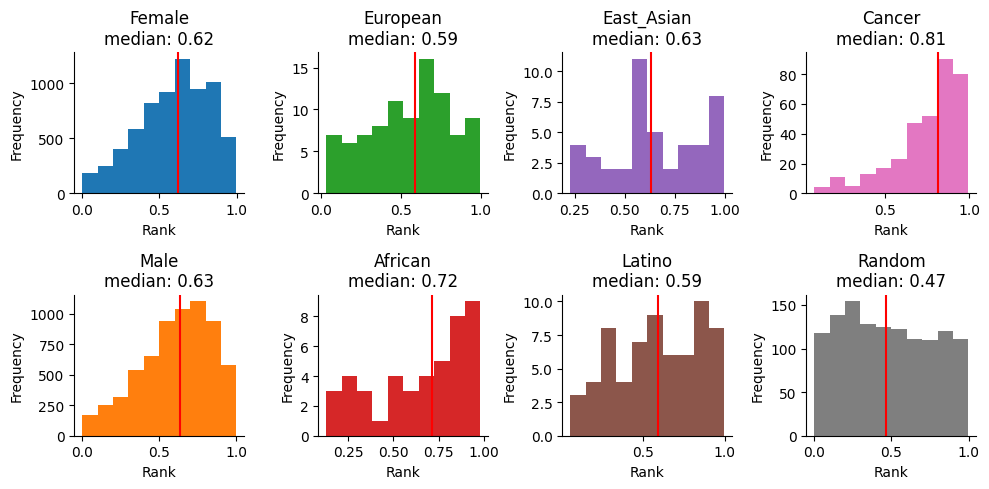

In [13]:
# do a histogram of the rank of each population
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
populations = ['Female','Male','European','African','East_Asian','Latino','Cancer','Random']

fig, axes = plt.subplots(2,4,figsize=(10,5))
for i,pop in enumerate(populations):
    x = i%2
    y = i//2
    df_pop = df[df['population']==pop]
    axes[x,y].hist(df_pop['rank'],label=pop,color=colors[i])
    
    # remove top and right border
    axes[x,y].spines['top'].set_visible(False)
    axes[x,y].spines['right'].set_visible(False)
    # set x and y labels
    axes[x,y].set_xlabel('Rank')
    axes[x,y].set_ylabel('Frequency')
    # set the median value as a vertical line
    axes[x,y].axvline(df_pop['rank'].median(),color='red',label='median')
    med = df_pop['rank'].median()
    axes[x,y].set_title(pop + f'\nmedian: {med:.2f}')
    
# save figure
plt.tight_layout()
plt.savefig('../Figures/group_comparison_degree_v_rank_hists.png',dpi=300,bbox_inches='tight')
plt.show()

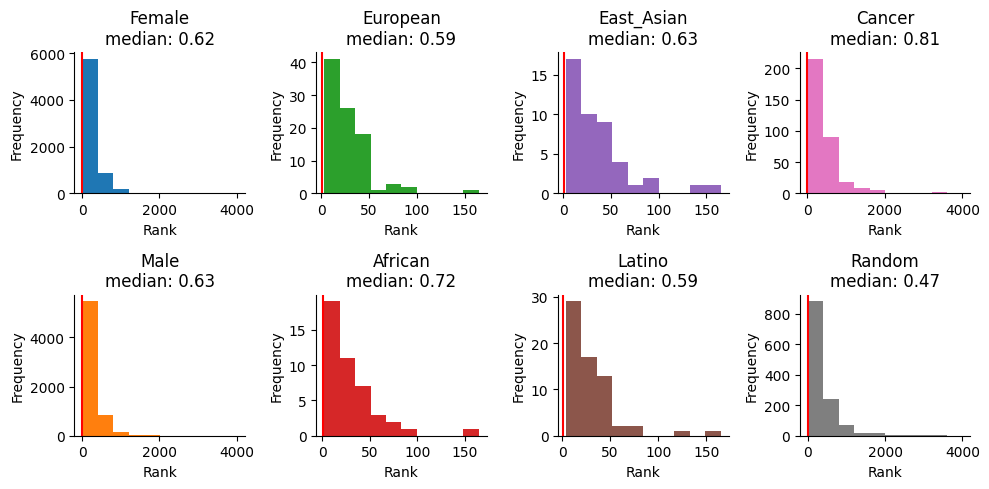

In [14]:
# do a histogram of the rank of each population

fig, axes = plt.subplots(2,4,figsize=(10,5))
for i,pop in enumerate(populations):
    x = i%2
    y = i//2
    df_pop = df[df['population']==pop]
    axes[x,y].hist(df_pop['given_entity_degree'],label=pop,color=colors[i])
    
    # remove top and right border
    axes[x,y].spines['top'].set_visible(False)
    axes[x,y].spines['right'].set_visible(False)
    # set x and y labels
    axes[x,y].set_xlabel('Rank')
    axes[x,y].set_ylabel('Frequency')
    # set the median value as a vertical line
    axes[x,y].axvline(df_pop['rank'].median(),color='red',label='median')
    med = df_pop['rank'].median()
    axes[x,y].set_title(pop + f'\nmedian: {med:.2f}')
    
# save figure
plt.tight_layout()
plt.savefig('../Figures/group_comparison_degree_v_rank_hists.png',dpi=300,bbox_inches='tight')
plt.show()   

Female 0.6264109951353138
Male 0.6420272057434347
European 0.5909885231190668
African 0.7580881311103764
East_Asian 0.6200585651537336
Latino 0.5895007792943843
Cancer 0.9104477611940298
Random 0.49560740600793496


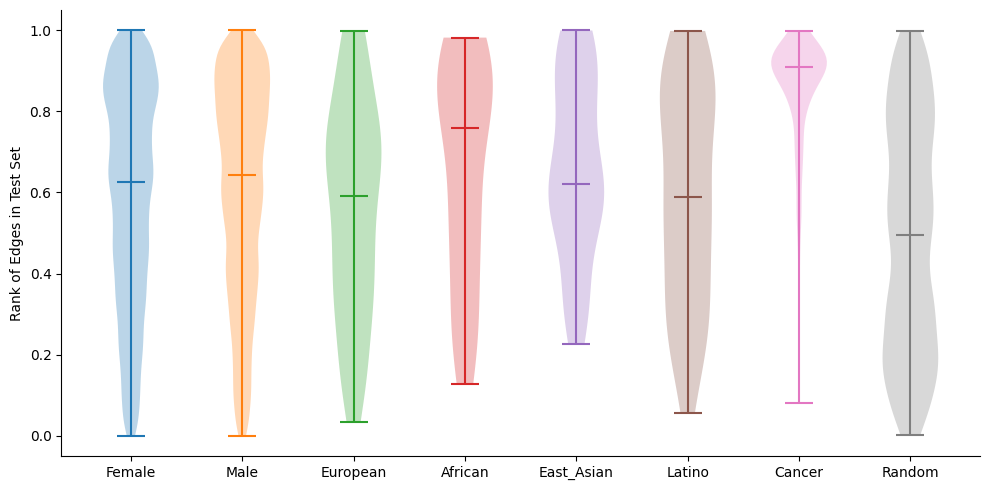

In [9]:
# violin plots of median rank

populations = ['Female','Male','European','African','East_Asian','Latino','Cancer','Random']

fig, ax = plt.subplots(figsize=(10,5))
for i,pop in enumerate(populations):
    x = i%2
    y = i//2
    df_pop = non_medianed_df[non_medianed_df['population']==pop]
    # violin plot of the rank   
    ax.violinplot(df_pop['rank'],positions=[i],showmedians=True)
    
    # remove top and right border
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # set x and y labels
    ax.set_ylabel('Rank of Edges in Test Set')
    # set the median value as a vertical line
    print(pop,df_pop['rank'].median())

# label the x ticks
ax.set_xticks(range(len(populations)))
ax.set_xticklabels(populations)
    
# save figure
plt.tight_layout()
plt.savefig('../Figures/group_comparison_degree_v_rank_hists.png',dpi=300,bbox_inches='tight')
plt.show()   